## Dataset Generator

> @ Author: Chen Wei

In [1]:
import os, copy, itertools, csv
import cv2 as cv
import numpy as np
import mediapipe as mp

2024-04-30 03:37:59.388799: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
def get_bounding_rect_and_landmark_points(image, landmarks):
    image_width, image_height = image.shape[1], image.shape[0]
    landmark_points = []
    
    for landmark in landmarks[0].landmark:
        landmark_x = min(int(landmark.x * image_width), image_width - 1)
        landmark_y = min(int(landmark.y * image_height), image_height - 1)
        landmark_point = [landmark_x, landmark_y]
        landmark_points.append(landmark_point)
        
    x, y, w, h = cv.boundingRect(np.array(landmark_points))
    return [x, y, x+w, y+h], landmark_points

In [3]:
def pre_process_landmark(landmark_points):
    temp_landmark_points = copy.deepcopy(landmark_points)
    
    # Convert to relative coordinates
    base_x = temp_landmark_points[0][0]
    base_y = temp_landmark_points[0][1]
    
    index = 1
    for landmark_point in temp_landmark_points[1:]:
        temp_landmark_points[index][0] = temp_landmark_points[index][0] - base_x
        temp_landmark_points[index][1] = temp_landmark_points[index][1] - base_y
        index += 1
    
    # Convert to a one-dimensional list
    temp_landmark_points = list(itertools.chain.from_iterable(temp_landmark_points))
    
    # normalize list
    max_value = max(temp_landmark_points, key=abs)
    temp_landmark_points = list(map(lambda x: x/max_value, temp_landmark_points))
    
    return temp_landmark_points

In [4]:
os.chdir("..")
root_path = os.getcwd()
root_path

'/mnt/f/CSCI1430/Gesture-Nauts'

In [5]:
dataset_path = os.path.join(root_path, "dataset/ori_dataset")

csv_data_path = os.path.join(root_path, "dataset/keypoint.csv")
csv_data_file = open(csv_data_path, "w", newline="")
csv_data_writer = csv.writer(csv_data_file)

csv_label_path = os.path.join(root_path, "dataset/keypoint_classifier_label.csv")
csv_label_file = open(csv_label_path, "w", newline="")
csv_label_writer = csv.writer(csv_label_file)

mp_hands = mp.solutions.hands
hands = mp_hands.Hands(
    static_image_mode=True,
    max_num_hands=1,
    min_detection_confidence=0.5)

class_name = None
class_index = -1
for root, dirs, files in os.walk(dataset_path, topdown=False):
    if root.endswith(".ipynb_checkpoints") or root.endswith("dataset"):
            continue
    for file in files:
        if file.startswith("."): continue
        new_class_name = root.split("/")[-1]
        if class_name != new_class_name:
            class_name = new_class_name
            print("class_name: {}".format(class_name))
            class_index += 1
            csv_label_writer.writerow([class_name])
        
        file_path = os.path.join(root, file)
        image = cv.imread(file_path)
        flip_image = cv.flip(image, 1)
        debug_image = copy.deepcopy(flip_image)
        rgb_image = cv.cvtColor(flip_image, cv.COLOR_BGR2RGB)
        results = hands.process(rgb_image)
        if results.multi_hand_landmarks is not None:
            hand_landmarks = results.multi_hand_landmarks
            handedness = results.multi_handedness
            brect, landmark_points = get_bounding_rect_and_landmark_points(debug_image, hand_landmarks) # [x, y, x+w, y+h], landmark_points
            pre_processed_landmark_points = pre_process_landmark(landmark_points)
            csv_data_writer.writerow([class_index, *pre_processed_landmark_points])
            
            

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


class_name: call


KeyboardInterrupt: 

class_name: call
None
[classification {
  index: 1
  score: 0.9296208620071411
  label: "Right"
}
]
[692, 635, 859, 848]


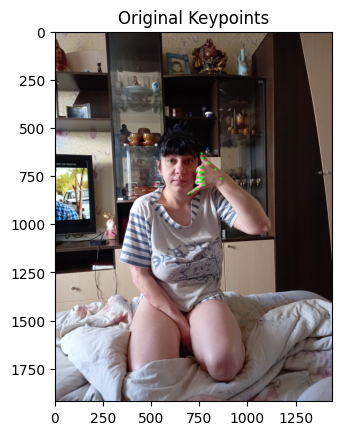

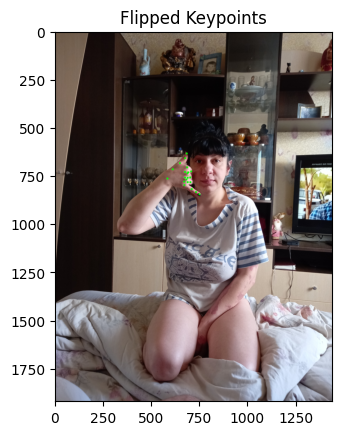

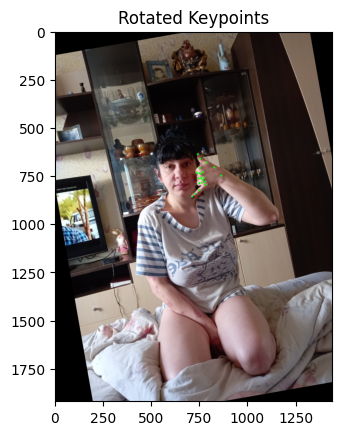

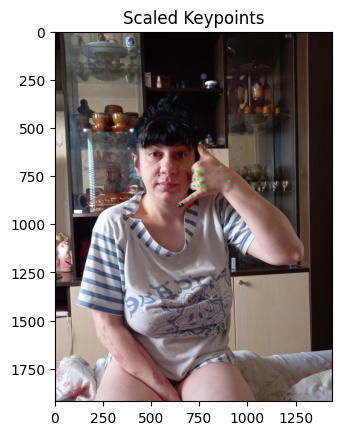

In [17]:
import matplotlib.pyplot as plt

dataset_path = os.path.join(root_path, "dataset/ori_dataset")

# csv_data_path = os.path.join(root_path, "dataset/keypoint.csv")
# csv_data_file = open(csv_data_path, "w", newline="")
# csv_data_writer = csv.writer(csv_data_file)

csv_label_path = os.path.join(root_path, "dataset/keypoint_classifier_label.csv")
csv_label_file = open(csv_label_path, "w", newline="")
csv_label_writer = csv.writer(csv_label_file)

def plot_keypoints(image, keypoints):
    output_image = copy.deepcopy(image)
    for point in keypoints:
        cv.circle(output_image, (int(point[0]), int(point[1])), 5, (0, 255, 0), -1)  # Green dots
    return output_image

def flip_keypoints(keypoints, image_width):
    # Flip keypoints horizontally
    flipped_keypoints = [[image_width - x, y] for x, y in keypoints]
    return flipped_keypoints
def rotate_keypoints(keypoints, angle, center):
    angle_rad = np.deg2rad(angle)
    R = np.array([[np.cos(angle_rad), -np.sin(angle_rad)],
                  [np.sin(angle_rad),  np.cos(angle_rad)]])
    rotated_keypoints = []
    for x, y in keypoints:
        shifted_x = x - center[0]
        shifted_y = y - center[1]
        rotated_x, rotated_y = R @ [shifted_x, shifted_y]
        rotated_keypoints.append([rotated_x + center[0], rotated_y + center[1]])
    return rotated_keypoints
def scale_keypoints(keypoints, scale_factor, center):
    scaled_keypoints = []
    for x, y in keypoints:
        scaled_x = center[0] + scale_factor * (x - center[0])
        scaled_y = center[1] + scale_factor * (y - center[1])
        scaled_keypoints.append([scaled_x, scaled_y])
    return scaled_keypoints
def translate_keypoints(keypoints, dx, dy):
    translated_keypoints = [[x + dx, y + dy] for x, y in keypoints]
    return translated_keypoints
def rotate_image(image, angle, center=None):
    (h, w) = image.shape[:2]
    if center is None:
        center = (w // 2, h // 2)
    M = cv.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv.warpAffine(image, M, (w, h))
    return rotated, M

def scale_image(image, scale_factor, center=None):
    if center is None:
        center = (image.shape[1] // 2, image.shape[0] // 2)
    M = cv.getRotationMatrix2D(center, 0, scale_factor)
    scaled = cv.warpAffine(image, M, (image.shape[1], image.shape[0]))
    return scaled, M

def translate_image(image, dx, dy):
    M = np.float32([[1, 0, dx], [0, 1, dy]])
    translated = cv.warpAffine(image, M, (image.shape[1], image.shape[0]))
    return translated, M

def plot_image_and_keypoints(image, keypoints):
    plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
    for x, y in keypoints:
        plt.scatter(x, y, c='red', s=40)
    plt.axis('off')
    plt.show()
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(
    static_image_mode=True,
    max_num_hands=1,
    min_detection_confidence=0.5)

class_name = None
class_index = -1
i=0
for root, dirs, files in os.walk(dataset_path, topdown=False):
    if root.endswith(".ipynb_checkpoints") or root.endswith("dataset"):
            continue
    for file in files:
        if file.startswith("."): continue
        new_class_name = root.split("/")[-1]
        if class_name != new_class_name:
            class_name = new_class_name
            print("class_name: {}".format(class_name))
            class_index += 1
            csv_label_writer.writerow([class_name])
        
        file_path = os.path.join(root, file)
        image = cv.imread(file_path)
        flip_image = cv.flip(image, 1)
        debug_image = copy.deepcopy(flip_image)
        rgb_image = cv.cvtColor(flip_image, cv.COLOR_BGR2RGB)
        results = hands.process(rgb_image)
        print(results.multi_handedness)
        # print(results.multi_hand_landmarks)
        if results.multi_hand_landmarks is not None:
            hand_landmarks = results.multi_hand_landmarks
            handedness = results.multi_handedness
            brect, landmark_points = get_bounding_rect_and_landmark_points(debug_image, hand_landmarks) # [x, y, x+w, y+h], landmark_points
            print(brect)
            center=(brect[0]+brect[2])//2, (brect[1]+brect[3])//2
            # print(landmark_points)
            visualized_image = plot_keypoints(debug_image, landmark_points)
            plt.imshow(cv.cvtColor(visualized_image, cv.COLOR_BGR2RGB))
            plt.title('Original Keypoints')
            plt.show()
            flipped_landmark_points = flip_keypoints(landmark_points, image.shape[1])
            horizontal_flipped_visualized_image = plot_keypoints(image, flipped_landmark_points)
            plt.imshow(cv.cvtColor(horizontal_flipped_visualized_image, cv.COLOR_BGR2RGB))
            plt.title('Flipped Keypoints')
            plt.show()
            rotated_image, rot_matrix = rotate_image(debug_image, 10, center=center)
            rotated_keypoints = rotate_keypoints(landmark_points, angle=-10, center=center)
            rotated_image=plot_keypoints(rotated_image, rotated_keypoints)
            plt.imshow(cv.cvtColor(rotated_image, cv.COLOR_BGR2RGB))
            plt.title('Rotated Keypoints')
            plt.show()

            scaled_image, scale_matrix = scale_image(debug_image, scale_factor=1.5, center=center)
            scaled_keypoints = scale_keypoints(landmark_points, scale_factor=1.5, center=center)
            scaled_image=plot_keypoints(scaled_image, scaled_keypoints)
            plt.imshow(cv.cvtColor(scaled_image, cv.COLOR_BGR2RGB))
            plt.title('Scaled Keypoints')
            plt.show()
            
            # translated_image, translate_matrix = translate_image(debug_image, dx=10, dy=-20)
            # translated_keypoints = translate_keypoints(landmark_points, dx=10, dy=-20)
            # translated_image=plot_keypoints(translated_image, translated_keypoints)
            # plt.imshow(cv.cvtColor(translated_image, cv.COLOR_BGR2RGB))
            # plt.title('Translated Keypoints')
            # plt.show()
            
            
            pre_processed_landmark_points = pre_process_landmark(landmark_points)
            csv_data_writer.writerow([class_index, *pre_processed_landmark_points])
        i+=1
        if i==2:
            break
    break
            
            

## With Data Augmentation

In [21]:
import matplotlib.pyplot as plt

dataset_path = os.path.join(root_path, "dataset/ori_dataset")

csv_data_path = os.path.join(root_path, "dataset/keypoint.csv")
csv_data_file = open(csv_data_path, "w", newline="")
csv_data_writer = csv.writer(csv_data_file)

csv_label_path = os.path.join(root_path, "dataset/keypoint_classifier_label.csv")
csv_label_file = open(csv_label_path, "w", newline="")
csv_label_writer = csv.writer(csv_label_file)

mp_hands = mp.solutions.hands
hands = mp_hands.Hands(
    static_image_mode=True,
    max_num_hands=1,
    min_detection_confidence=0.5)

class_name = None
class_index = -1
i=0


# augment parameters(rotate, scale, flip), flip doesn't need param.

angle_list=[-10, 10]
scale_factor_list=[1.5, 0.5]
for root, dirs, files in os.walk(dataset_path, topdown=False):
    if root.endswith(".ipynb_checkpoints") or root.endswith("dataset"):
            continue
    for file in files:
        if file.startswith("."): continue
        new_class_name = root.split("/")[-1]
        if class_name != new_class_name:
            class_name = new_class_name
            print("class_name: {}".format(class_name))
            class_index += 1
            csv_label_writer.writerow([class_name])
        
        file_path = os.path.join(root, file)
        image = cv.imread(file_path)
        flip_image = cv.flip(image, 1)
        debug_image = copy.deepcopy(flip_image)
        rgb_image = cv.cvtColor(flip_image, cv.COLOR_BGR2RGB)
        results = hands.process(rgb_image)
        # print(results.multi_handedness)
        # print(results.multi_hand_landmarks)
        if results.multi_hand_landmarks is not None:
            hand_landmarks = results.multi_hand_landmarks
            handedness = results.multi_handedness
            brect, landmark_points = get_bounding_rect_and_landmark_points(debug_image, hand_landmarks) # [x, y, x+w, y+h], landmark_points
            # print(brect)
            center=(brect[0]+brect[2])//2, (brect[1]+brect[3])//2
            
            pre_processed_landmark_points = pre_process_landmark(landmark_points)
            csv_data_writer.writerow([class_index, *pre_processed_landmark_points])
            
            flipped_landmark_points = flip_keypoints(landmark_points, image.shape[1])
            pre_process_flipped_landmark_points = pre_process_landmark(flipped_landmark_points)
            csv_data_writer.writerow([class_index, *pre_process_flipped_landmark_points])
            # horizontal_flipped_visualized_image = plot_keypoints(image, flipped_landmark_points)
            
            
            for angle in angle_list:
                rotated_image, rot_matrix = rotate_image(debug_image, angle, center=center)
                rotated_keypoints = rotate_keypoints(landmark_points, angle=-angle, center=center)
                # rotated_image=plot_keypoints(rotated_image, rotated_keypoints)
                pre_processed_rotated_landmark_points = pre_process_landmark(rotated_keypoints)
                csv_data_writer.writerow([class_index, *pre_processed_rotated_landmark_points])
        
            # scaled_image, scale_matrix = scale_image(debug_image, scale_factor=1.5, center=center)
            for scale in scale_factor_list:
                scaled_keypoints = scale_keypoints(landmark_points, scale_factor=scale, center=center)
                pre_processed_scaled_landmark_points = pre_process_landmark(scaled_keypoints)
                csv_data_writer.writerow([class_index, *pre_processed_scaled_landmark_points])

            
            
            
  
            

class_name: call
class_name: dislike
class_name: fist
class_name: four
class_name: like
class_name: mute
class_name: ok
class_name: one
class_name: palm
class_name: peace
class_name: peace_inverted
class_name: rock
class_name: stop
class_name: stop_inverted
class_name: three
class_name: three2
class_name: two_up
class_name: two_up_inverted


In [ ]:
def dataset_loader():
    pass

In [ ]:
print("done")

done
